# Selection of krypton events in terms of S1 and S2

## Authors: JAH, GML, JJGC

### Description:

- This is a template to illustrate selection and filter of kdst events in order to compute lifetime and geometry maps.
- It uses as example run 6206. During this run, in addition of Krypton there were Cd and Th sources in the chamber.
- Cs and Th sources result in X-rays that introduce a slight contamination in the Kr data sample, cleaned up by the selection and filtering.
- The most important cleaning cut is to require 1 S1 and 1 S2, in the range of energies compatible with Krypton. 
- Additional cuts are illustrated in the NB

In [352]:
import time
print("Last updated on ", time.asctime())

Last updated on  Wed Aug  8 10:03:00 2018


In [298]:
run_number  = 6206
file_range  = 0, 10000  

input_path  = f"$IC_DATA/kdst"
output_path = f"$IC_DATA/dst"
log_path    = f"$IC_DATA/log"
trigger     = ''
tags        = 'v0.9.7-19-g574c657_20180710'

bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"
write_filtered_dst = True

In [139]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob


In [141]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units


In [380]:
from krcal.core.io_functions       import filenames_from_paths
from krcal.core.io_functions       import write_monitor_vars
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2d, plot_histo

In [348]:
from krcal.core.kr_types           import PlotLabels
from krcal.core.analysis_functions import kr_ranges_and_bins
from krcal.core.analysis_functions import kr_event
from krcal.core.analysis_functions import krg_event
from krcal.core.analysis_functions import selection_info
from krcal.core.analysis_functions import selection_in_band
from krcal.core.analysis_functions import plot_selection_in_band
from krcal.core.s1s2_functions     import s1d_from_dst
from krcal.core.s1s2_functions     import s2d_from_dst
from krcal.core.s1s2_functions     import plot_s1histos
from krcal.core.s1s2_functions     import plot_s2histos

In [349]:
from krcal.core.plt_functions      import plot_xy_density
from krcal.core.plt_functions      import plot_s1_vs_z
from krcal.core.plt_functions      import plot_s2_vs_z
from krcal.core.plt_functions      import plot_s2_vs_s1
from krcal.core.plt_functions      import plot_q_vs_s2
from krcal.core.plt_functions      import plot_energy_distributions
from krcal.core.plt_functions      import plot_energy_vs_t


In [350]:
import krcal.dev.corrections       as corrections 
import krcal.utils.hst_extend_functions as hst

### Input/output 

In [143]:
input_dst_filenames, output_dst_filename, log_filename = filenames_from_paths(run_number,
                                                                              input_path,
                                                                              output_path,
                                                                              log_path,
                                                                              trigger,
                                                                              tags,
                                                                              file_range)
                                                                              
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"log file   = {log_filename}")                       

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6206/kdst_0000_6206_v0.9.7-19-g574c657_20180710_krth.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6206/kdst_9999_6206_v0.9.7-19-g574c657_20180710_krth.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_9999.h5
log file   = /Users/jjgomezcadenas/Projects/ICDATA/log/log_6206_0000_9999.h5


In [146]:
dst_full           = load_dsts(input_dst_filenames, "DST", "Events")

/Users/jjgomezcadenas/Projects/IC/invisible_cities/io/dst_io.py:21: UserWarning:  does not exist: file = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6206/kdst_0070_6206_v0.9.7-19-g574c657_20180710_krth.h5 
  warnings.warn(f' does not exist: file = {filename} ', UserWarning)
/Users/jjgomezcadenas/Projects/IC/invisible_cities/io/dst_io.py:21: UserWarning:  does not exist: file = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6206/kdst_0293_6206_v0.9.7-19-g574c657_20180710_krth.h5 
  warnings.warn(f' does not exist: file = {filename} ', UserWarning)
/Users/jjgomezcadenas/Projects/IC/invisible_cities/io/dst_io.py:21: UserWarning:  does not exist: file = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6206/kdst_0350_6206_v0.9.7-19-g574c657_20180710_krth.h5 
  warnings.warn(f' does not exist: file = {filename} ', UserWarning)
/Users/jjgomezcadenas/Projects/IC/invisible_cities/io/dst_io.py:21: UserWarning:  does not exist: file = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6206/kdst_0409_6206_v0.9.7-19-

In [416]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 4976871 
Total number of events: 2782980


In [417]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [418]:
ntot = len(dst_full)
print(f"length of dst = {ntot}")

length of dst = 4976871


### S1/S2

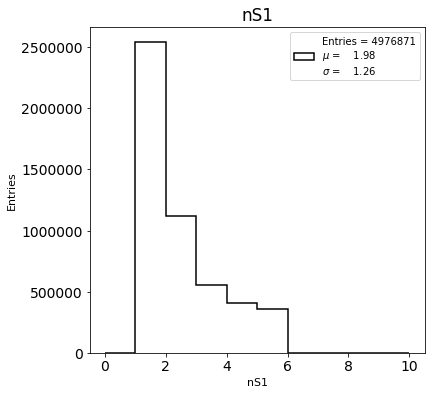

In [419]:
n, b = h1d(dst_full.nS1.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS1', y='Entries', title='nS1'))

In [420]:
fnS1 = n[n.argmax()]/np.sum(n)
print(f'fraction of S1s = {fnS1}')

fraction of S1s = 0.5103945832632591


#### Fraction of events with 1 S1 is 0.5, due to grass and high energy events. For Krypton select events with 1 S1

### Select events with 1 S1

In [421]:
dst1s1 = dst_full[dst_full.nS1==1]

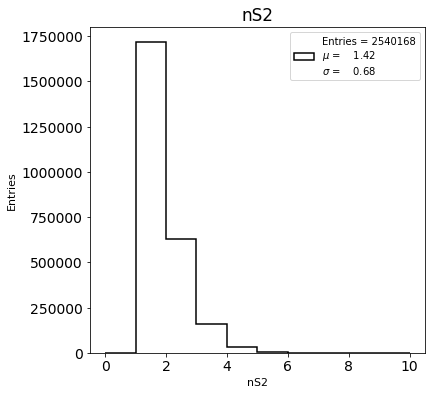

In [422]:
n, b = h1d(dst1s1.nS2.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS2', y='Entries', title='nS2'))

#### For Krypton select events with only 1 S2

In [423]:
fnS2 = n[n.argmax()]/np.sum(n)
print(f'fraction of S2s = {fnS2}')

fraction of S2s = 0.6757175115976581


### Select events with 1 S2

In [424]:
dst    = dst1s1[dst1s1.nS2==1]

In [425]:
n_full   = len(dst)
eff = n_full   / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {n_full}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 1716436: selection eff = 0.3448825577355732 


### S1 and S2 distributions

In [426]:
s1d = s1d_from_dst(dst)

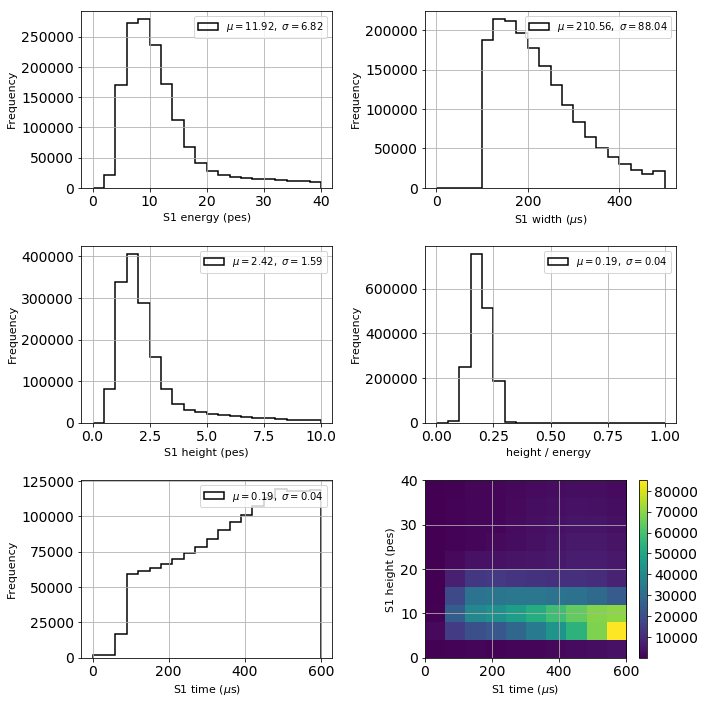

In [427]:
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

### Fiducial selection in S1

#### 2 < S1e < 30 pes, which cuts off very low and high energy events

In [428]:
s1e_range =(2, 30)

In [429]:
dst_s1e    = dst[in_range(dst.S1e, *s1e_range)] 

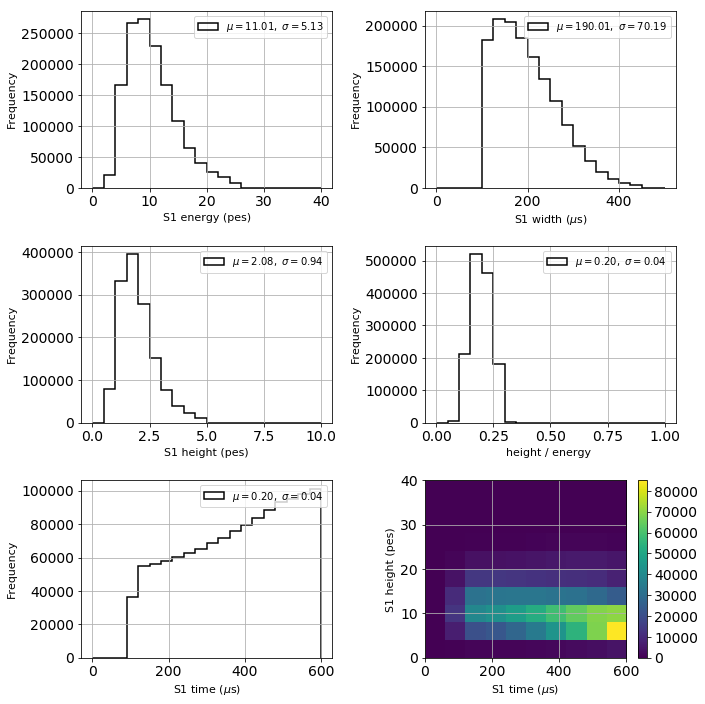

In [430]:
s1d = s1d_from_dst(dst_s1e, range_s1e = s1e_range)
plot_s1histos(dst_s1t,  s1d, bins=20, figsize=(10,10))

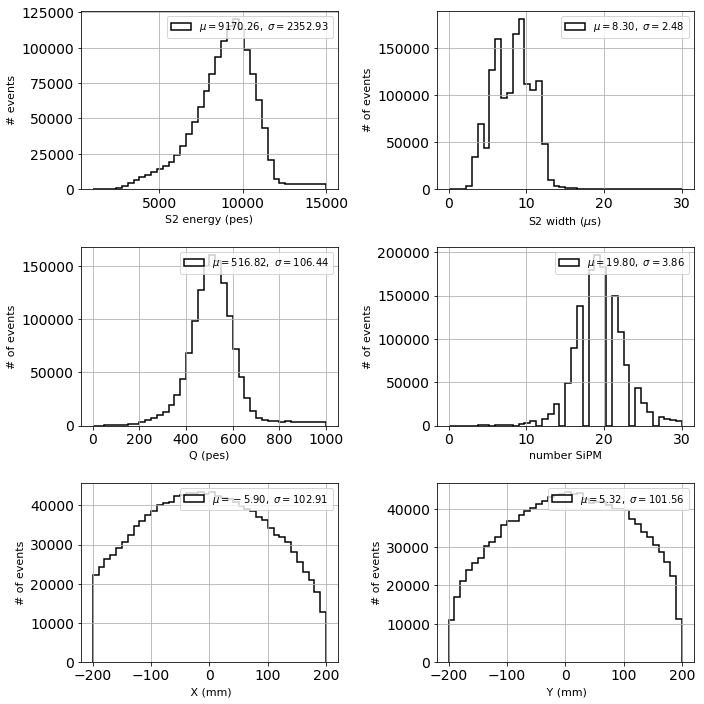

In [431]:
dst = dst_s1t
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=40, emin=1000, emax=15000, figsize=(10,10))

### Fiducial selection in S2

#### Nsipm >10, 2000 < S2e < 14000, 5 < s2w < 15, to define well behaved events

In [432]:
Nsipm_min = 10 
s2e_range =(2000, 14000)
s2w_range =(5, 15)
s2q_range =(200, 800)

In [433]:
dst_sipm    = dst[dst.Nsipm >Nsipm_min] 
dst_s2e    = dst_sipm[in_range(dst_sipm.S2e, *s2e_range)] 
dst_s2w    = dst_s2e[in_range(dst_s2e.S2w, *s2w_range)]
dst_s2q    = dst_s2w[in_range(dst_s2w.S2q, *s2q_range)]
dst = dst_s2q

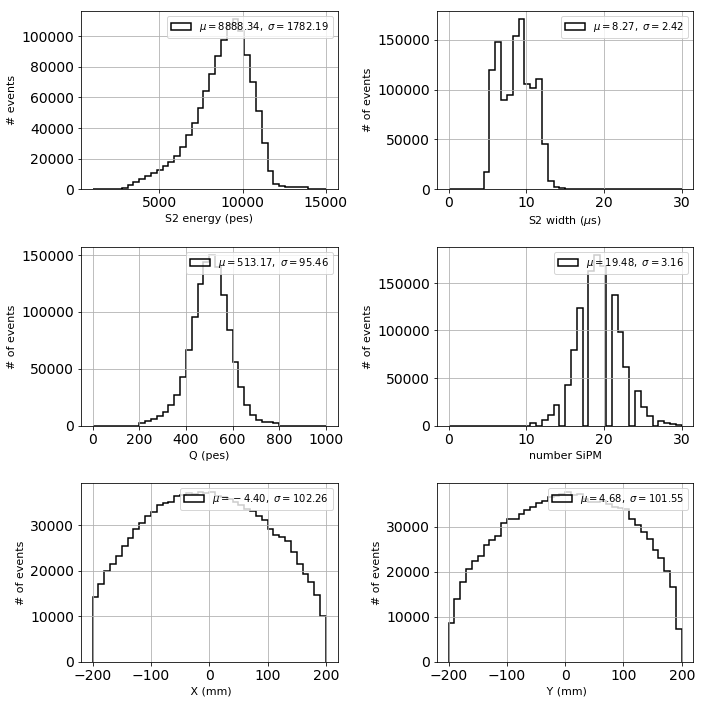

In [434]:
s2d = s2d_from_dst(dst_s2e)
plot_s2histos(dst, s2d, bins=40, emin=1000, emax=15000, figsize=(10,10))

### Define ranges and bins

In [435]:
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = (-220,  220),
                                                        yrange    = (-220,  220),
                                                        zrange    = (10,  550),
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 50,
                                                        s2qnbins  = 50,
                                                        tpsamples = 3600) # tsamples in seconds

### Time
- Extension in hours of data sample considered

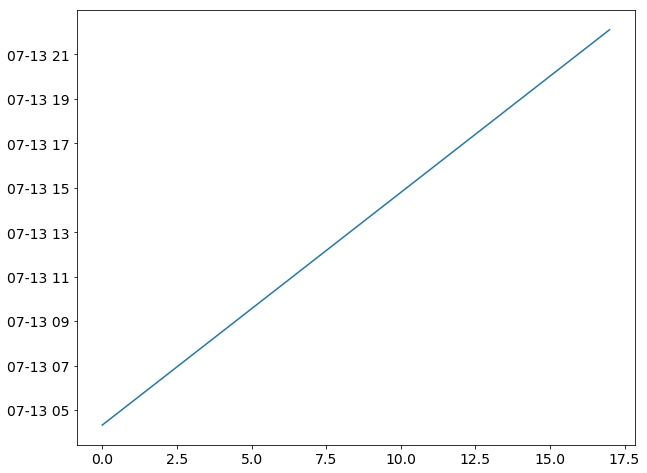

In [436]:
plt.plot(krTimes.timeStamps)

### Control distributions

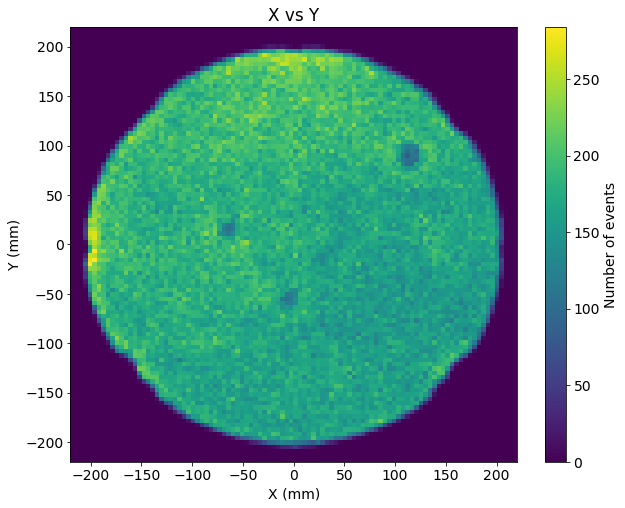

In [440]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

#### Notice concentration of events in (X,Y) = (0, -200), and (X,Y) = (200,0), due to X-rays emanating from sources.

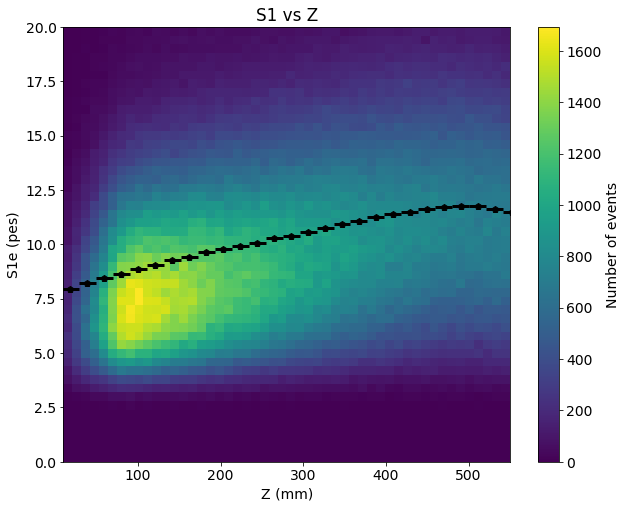

In [442]:
nevt = h2d(dst.Z, dst.S1e, krNbins.Z, krNbins.S1e, krRanges.Z, (0,20), 
           pltLabels=PlotLabels(x='Z (mm)', y='S1e (pes)', title='S1 vs Z'),
           profile=True,
           figsize=(10,8))

#### S1 vs Z distribution:

- Concentrated at low Z: This is due to the fact that gas flow is higher near the anode, and thus there is more krypton near the anode than near the cathode. 
- Increases as a function of Z. The closer to the cathode the larger S1
- Spread is large: This is due to large variation of solid angle, depending on (X,Y)

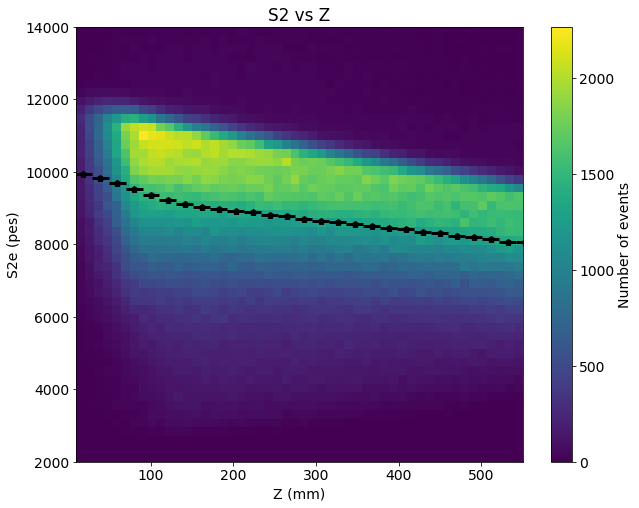

In [443]:
nevt = h2d(dst.Z, dst.S2e, krNbins.Z, krNbins.S1e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

#### S2 vs Z distribution:

- Concentrated at low Z: This is due to the fact that gas flow is higher near the anode, and thus there is more krypton near the anode than near the cathode. 
- Decreases as a function of Z, due to lifetime
- Spread is large: This is due to large variation of solid angle, depending on (X,Y)

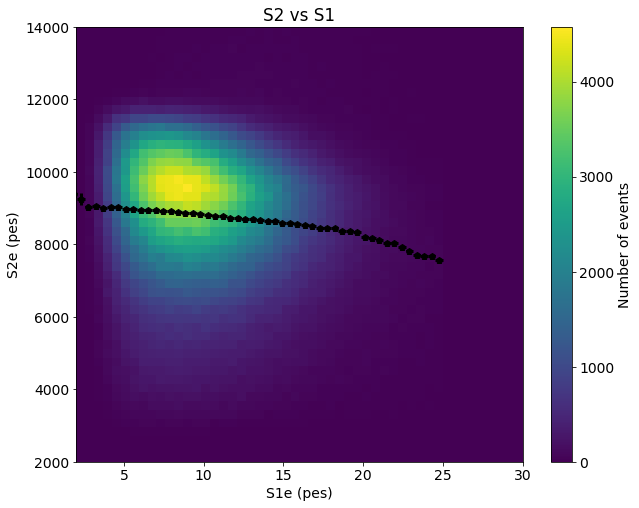

In [444]:
nevt = h2d(dst.S1e, dst.S2e, krNbins.S1e, krNbins.S2e, krRanges.S1e, krRanges.S2e, 
           pltLabels=PlotLabels(x='S1e (pes)', y='S2e (pes)', title='S2 vs S1'),
           profile=True,
           figsize=(10,8))

#### S2 vs S1 distribution:

- Small anti-correlation (more S2 less S1). 

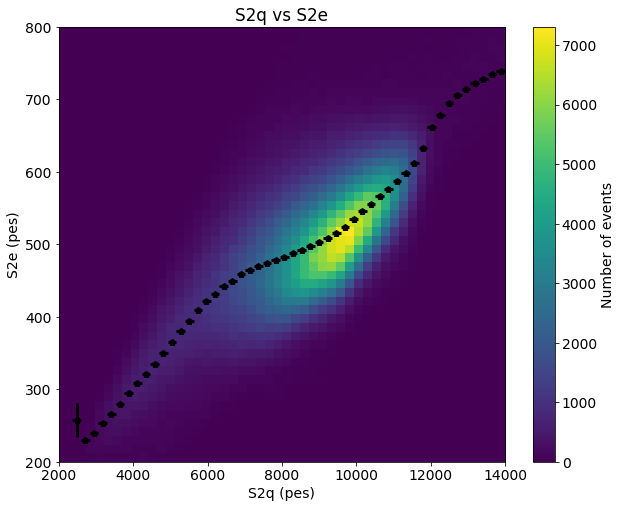

In [445]:
nevt = h2d(dst.S2e, dst.S2q, krNbins.S2e, krNbins.S2q, krRanges.S2e, krRanges.S2q, 
           pltLabels=PlotLabels(x='S2q (pes)', y='S2e (pes)', title='S2q vs S2e'),
           profile=True,
           figsize=(10,8))

#### S2 vs Q distribution:

- Clear correlation between S2 and Q 

### Select central region in R 

#### The effect is to reduce the dependence of geometrical corrections

In [242]:
dst_R     = dst[dst.R < 100]

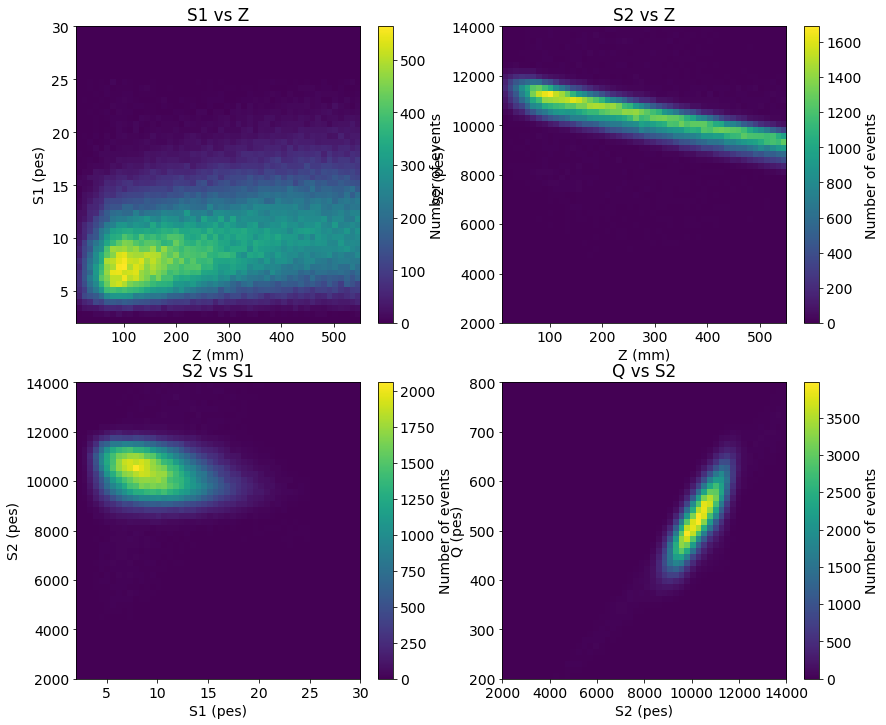

In [259]:
plot_energy_distributions(dst_R, krBins.Z, krBins.S1e, krBins.S2e, krBins.S2q, figsize=(14,12))

### Select central region in Z

- The effect is to reduce the dependence of lifetime

In [244]:
dst_core     = dst_R[dst_R.Z < 200]

### Energy in core

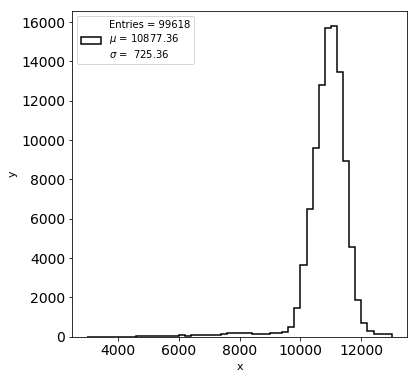

In [393]:
(_) = h1d(dst_core.S2e, bins = 50, range =(3000,13000), legendloc='upper left')

#### Notice tail below ~10,000 pes due to X rays

### Apply bootstrap corrections.

- One can correct S2e and S2q by geometrical corrections using an existing map (a bootstrap map). This has the effect to reduce the geometrical dependence on both distributions, permitting an additional filtering

In [261]:
kre = kr_event(dst)

In [262]:
bootstrap_correction_filename = os.path.expandvars(bootstrap_correction_filename)
calibrate = corrections.Calibration(bootstrap_correction_filename)
E, Q = calibrate(kre.X, kre.Y, None, kre.T, kre.S2e, kre.S2q)

calibration file : /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_corrections_run6206.h5
node             : geometry
Energy   scale :  1.0 (pes)
Lifetime scale : 2324.4 (us) 
Charge   scale :  1.0 (pes)


In [362]:
kge = krg_event(dst, Eg =E, Qg=Q, sel=False)

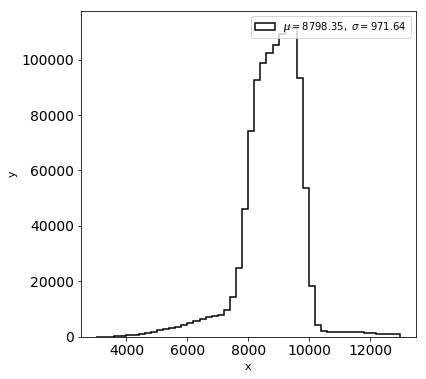

In [364]:
(_) = h1d(kge.Eg, bins = 50, range =(3000,13000))

#### Plot of E and Q corrected vs Z shows much less spread (XY corrections applied only remaining LT corrections)

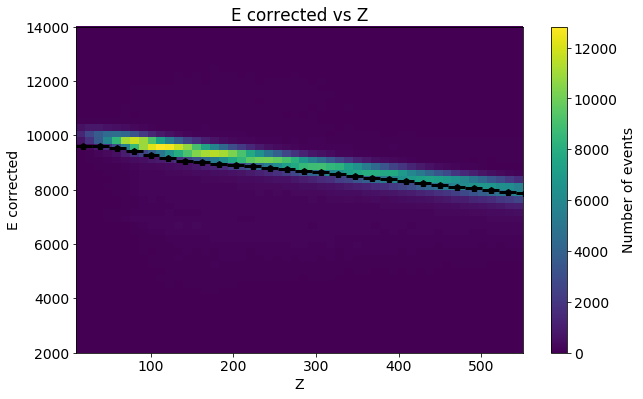

In [401]:
nevt = h2d(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z', y='E corrected', title='E corrected vs Z'),
           profile=True,
           figsize=(10,6))

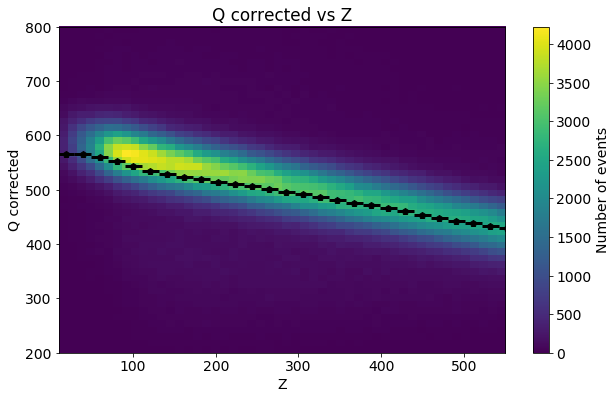

In [402]:
nevt = h2d(dst.Z, Q, krNbins.Z, krNbins.S2q, krRanges.Z, krRanges.S2q, 
           pltLabels=PlotLabels(x='Z', y='Q corrected', title='Q corrected vs Z'),
           profile=True,
           figsize=(10,6))

### Filter

In [276]:
range_krs2 = (7e+3,12e+3)

In [279]:
sel_krband, fpl, fph, hp, pp = selection_in_band(kre.Z, E,
                                                 range_z = krRanges.Z,
                                                 range_e = range_krs2,
                                                 nbins_z = 50,
                                                 nbins_e = 50,
                                                 nsigma  = 3.5)

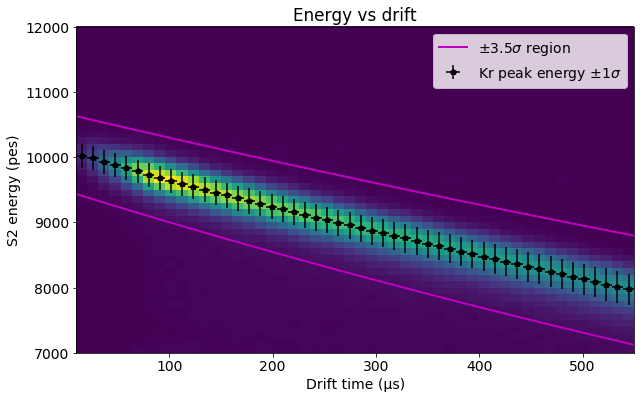

In [280]:
plot_selection_in_band(fpl, fph, hp, pp)

In [281]:
selection_info(sel_krband, 'Kr band')

Total number of selected candidates Kr band: 1017714 (87.1 %)


'Total number of selected candidates Kr band: 1017714 (87.1 %)'

In [365]:
kges = krg_event(dst, Eg =E, Qg=Q, sel=True, sel_mask=sel_krband)

### Energy before and after filter

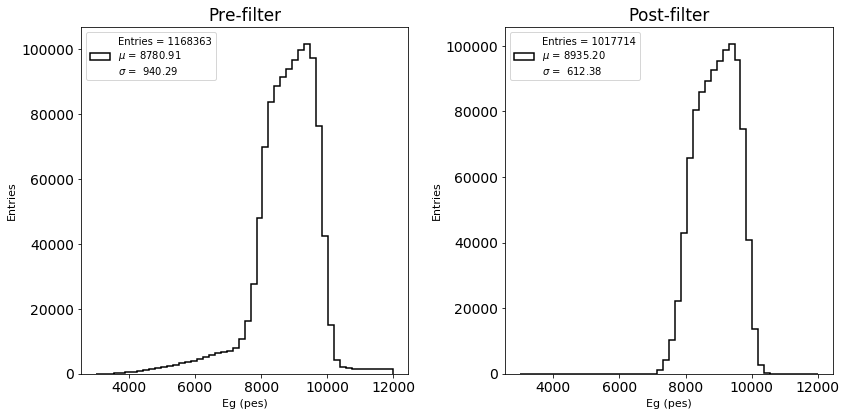

In [398]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(kge.Eg,  bins = 50, range =(3000,12000))
plot_histo(PlotLabels('Eg (pes)','Entries','Pre-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(kges.Eg,  bins = 50, range =(3000,12000))
plot_histo(PlotLabels('Eg (pes)','Entries','Post-filter'), ax, legendloc='upper left')
plt.tight_layout()

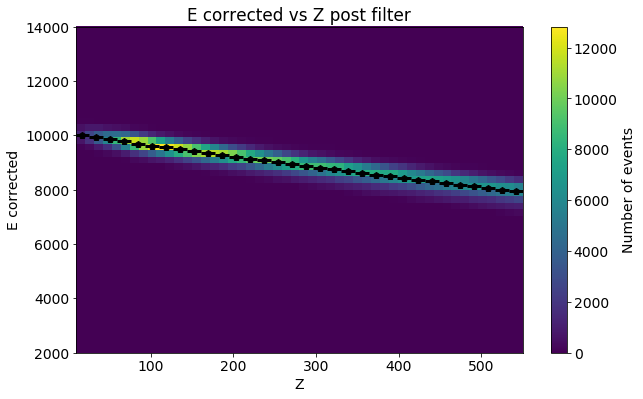

In [403]:
nevt = h2d(kges.Z, kges.Eg, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z', y='E corrected', title='E corrected vs Z post filter'),
           profile=True,
           figsize=(10,6))

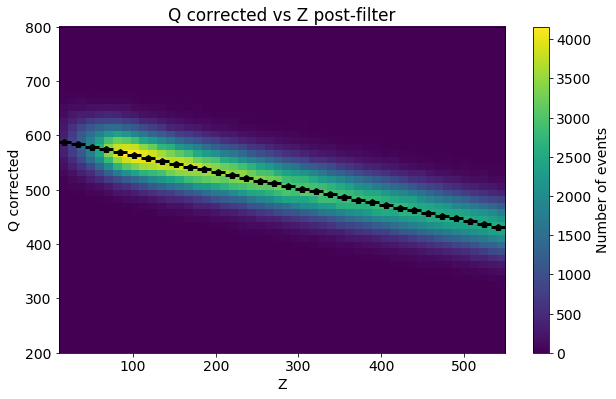

In [404]:
nevt = h2d(kges.Z, kges.Qg, krNbins.Z, krNbins.S2q, krRanges.Z, krRanges.S2q, 
           pltLabels=PlotLabels(x='Z', y='Q corrected', title='Q corrected vs Z post-filter'),
           profile=True,
           figsize=(10,6))

#### Notice how the filter cleans up the energy distributions. 

### Time evolution

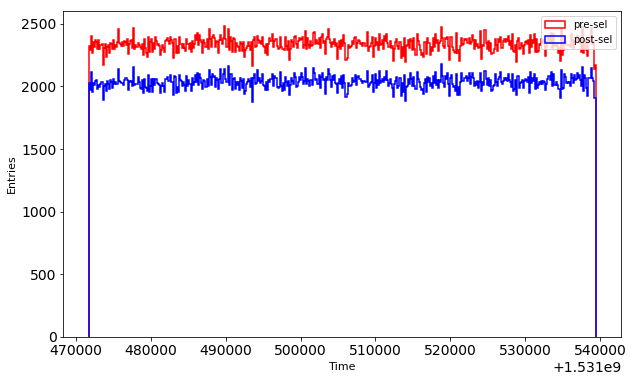

In [384]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
n, b    = h1(kge.T, bins=500, range = (kge.T.min(), kge.T.max()), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('Time','Entries',''), ax)
n, b    = h1(kges.T, bins=500, range = (kges.T.min(), kges.T.max()), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('Time','Entries',''), ax)

#### event density is constant, indicating a stable run

### S1 and Corrected E and Q as a function of T

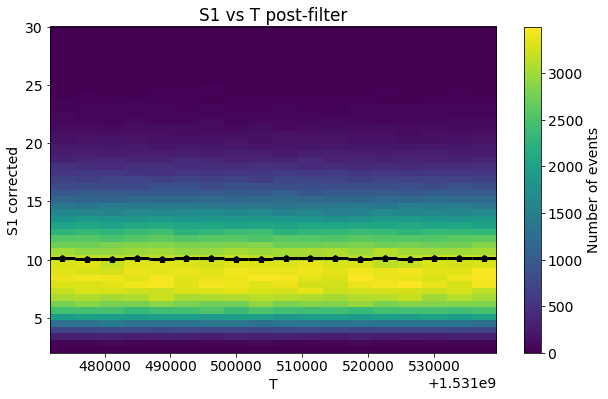

In [409]:
nevt = h2d(kges.T, kges.S1e, krNbins.T, krNbins.S1e, krRanges.T, krRanges.S1e, 
           pltLabels=PlotLabels(x='T', y='S1 corrected', title='S1 vs T post-filter'),
           profile=True,
           figsize=(10,6))

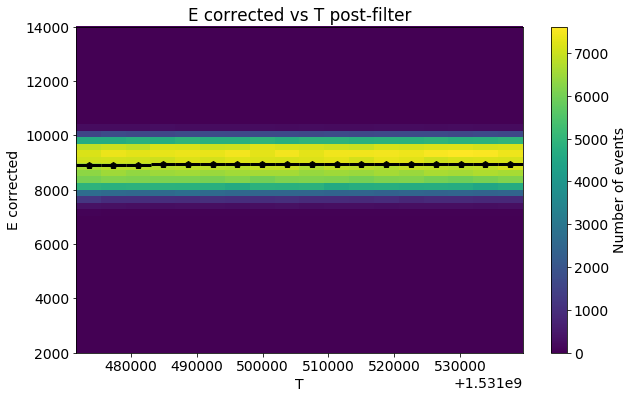

In [408]:
nevt = h2d(kges.T, kges.Eg, krNbins.T, krNbins.S2e, krRanges.T, krRanges.S2e, 
           pltLabels=PlotLabels(x='T', y='E corrected', title='E corrected vs T post-filter'),
           profile=True,
           figsize=(10,6))

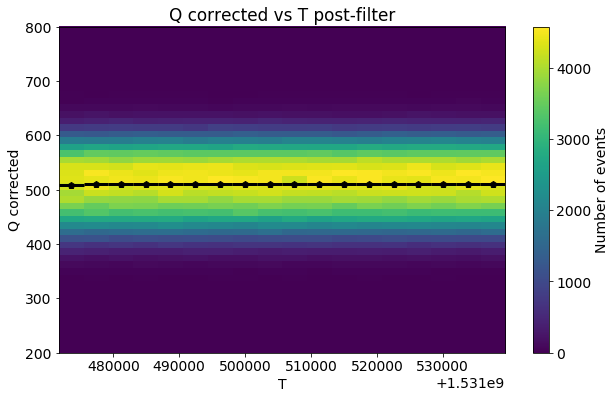

In [407]:
nevt = h2d(kges.T, kges.Qg, krNbins.T, krNbins.S2q, krRanges.T, krRanges.S2q, 
           pltLabels=PlotLabels(x='T', y='Q corrected', title='Q corrected vs T post-filter'),
           profile=True,
           figsize=(10,6))

### All amplitudes are constant as a function of time in an stable run

### Select dst 

In [446]:
dsts = dst[sel_krband]

### X vs Y again

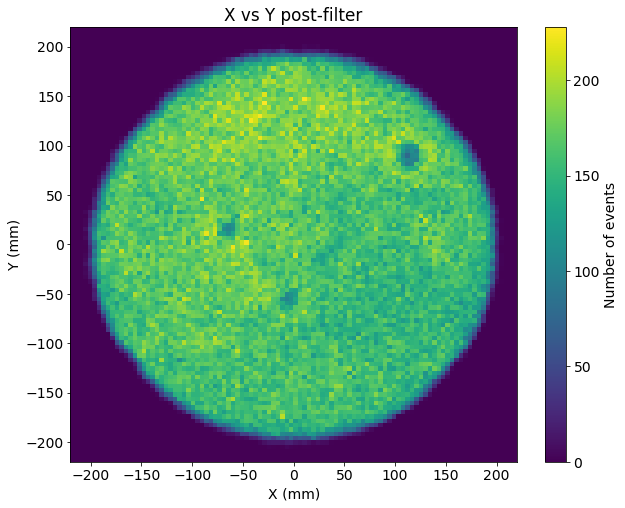

In [448]:
nevt = h2d(dsts.X, dsts.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y post-filter'),
           profile=False,
           figsize=(10,8))

#### Notice how the concentratoins due to X rays have dissappeared 

### Spatial distributions 

#### In R and Z

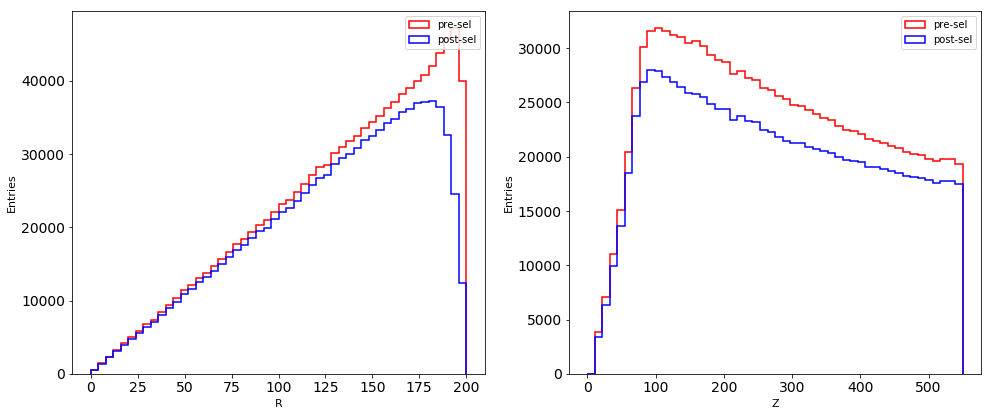

In [453]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
n, b    = h1(kge.R, bins=50, range = (0,200), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('R','Entries',''), ax)
n, b    = h1(kges.R, bins=50, range = (0,200), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('R','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
n, b    = h1(kge.Z, bins=50, range = (0,550), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('Z','Entries',''), ax)
n, b    = h1(kges.Z, bins=50, range = (0,550), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('Z','Entries',''), ax)
plt.tight_layout()

#### In X Y

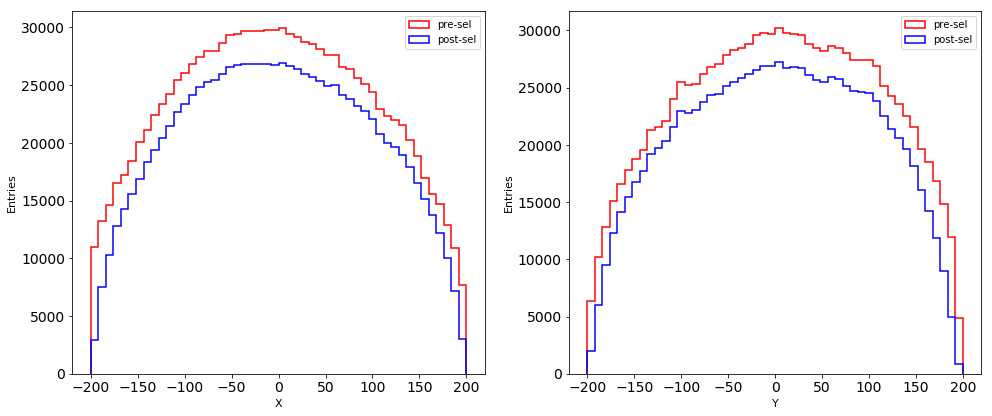

In [454]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
n, b    = h1(kge.X, bins=50, range = (-200,200), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('X','Entries',''), ax)
n, b    = h1(kges.X, bins=50, range = (-200,200), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('X','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
n, b    = h1(kge.Y, bins=50, range = (-200,200), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('X','Entries',''), ax)
n, b    = h1(kges.Y, bins=50, range = (-200,200), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('Y','Entries',''), ax)
plt.tight_layout()

### Charge and SiPM distributions

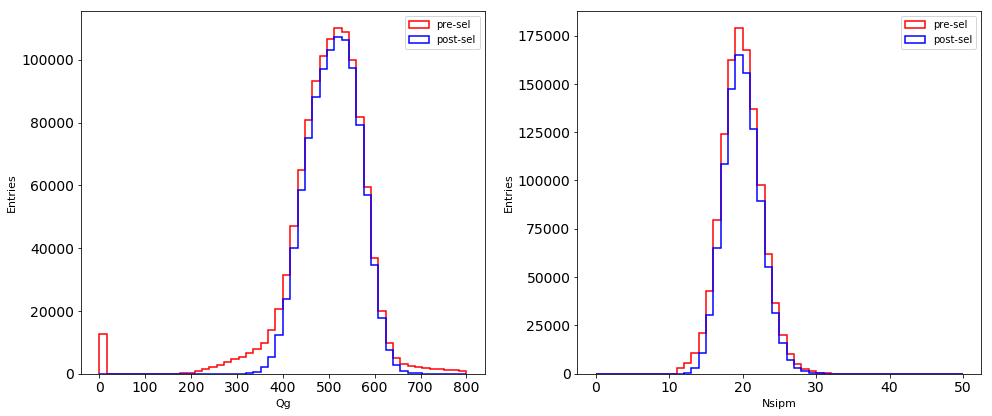

In [455]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
n, b    = h1(kge.Qg, bins=50, range = (0,800), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('Qg','Entries',''), ax)
n, b    = h1(kges.Qg, bins=50, range = (0,800), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('Qg','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
n, b    = h1(dst.Nsipm, bins=50, range = (0,50), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('Nsipm','Entries',''), ax)
n, b    = h1(dsts.Nsipm, bins=50, range = (0,50), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('Nsipm','Entries',''), ax)
plt.tight_layout()

### Write DST (merged and fiducial)

In [121]:
dst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [ ]:
#del dst['index']

In [456]:
if (write_filtered_dst):
    print('writing filtered dst ', output_dst_filename)
    kdst_write(dsts, output_dst_filename);

writing filtered dst  /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_9999.h5


## End of NB